# **Maestría en Inteligencia Artificial Aplicada**

## **Curso: Inteligencia Artificial y Aprendizaje Automático**

Tecnológico de Monterrey

Prof Luis Eduardo Falcón Morales

### **Actividad de la semana: Modelos basados en Árboles**


**Liliana Irais Beltrán Martínez A01797565:**


# **PARTE - 1 - Bosque Aleatorio (Random Forest) - Clasificación**

In [289]:
# Importamos lo necesario para la actividad

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
import shap

from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split, RandomizedSearchCV, learning_curve, cross_val_score, StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc, precision_recall_curve, average_precision_score
from sklearn.metrics import make_scorer, recall_score, accuracy_score, precision_score, f1_score
from sklearn.preprocessing import StandardScaler
from imblearn.metrics import classification_report_imbalanced
from sklearn.dummy import DummyClassifier
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split, GridSearchCV


from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTEENN

np.random.seed(17)

In [290]:
# Para esta actividad vamos a generar datos sintéticos para un problema de
# clasificación binario utilizando "make_classification" de scikitlearn.


# Recuerda consultar la documentación para mayor información:
# https://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_classification.html


# Utilizaremos los siguientes valores de los hiperparámetros de make_classification:
# - n_samples: número de muestras o registros a generar.
# - n_features: número total de características o variables de entrada X.
# - n_informative: número de características informativas o independientes.
# - n_redundant: número de características redundantes.
# - weights: pesos para las clases [0,1]-->[Clase_Mayoritaria_Negativa(0), clase_minoritaria_positiva(1)].
# - class_sep: separación entre clases (mayor valor --> clases más separables y menos complejo).
# - flip_y: fracción de ejemplos cuya clase se cambia aleatoriamente (ruido), para hacerlo más complejo.
# - random_state: semilla para reproducibilidad.

X, y = make_classification(
    n_samples=10_000,          # 10,000 registros
    n_features=20,             # factores en total
    n_informative=15,          # factores informativos o variables de entrada independientes
    n_redundant=5,             # factores redundantes (dependientes). Para añadir complejidad usamos valor > 0
    weights=[0.88, 0.12],      # Desbalance de clases: Mayoritaria clase 0; minoritaria clase 1
    class_sep=1.0,             # Separación entre clases
    n_classes=2,               # Dos clases
    n_clusters_per_class=1,    # Para agregar complejidad adicional considera valores > 1
    flip_y=0.01,              # Añadir algo de ruido. default 0.01
    random_state=17,
)

In [291]:
# A continuación transformamos el conjunto de datos para que ya
# están escalados alrededor del cero y donde todas las variables
# sean numéricas.

# Escalamos las características para que estén en el mismo rango:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Creamos un DataFrame para su mejor manejo
feature_names = [f'feature_{i+1}' for i in range(20)]
df = pd.DataFrame(X_scaled, columns=feature_names)
df['target'] = y

print(f"Total de registros generados: {len(df)}")
print(f"Distribución de clases: {df['target'].value_counts(normalize=True).mul(100).round(1).astype(str) + '%'}")
print(f"Cantidad de factores: {len(feature_names)}")

Total de registros generados: 10000
Distribución de clases: target
0    87.7%
1    12.3%
Name: proportion, dtype: object
Cantidad de factores: 20


In [292]:
pd.DataFrame(df).describe().T

,count,mean,std,min,25%,50%,75%,max
feature_1,10000.0,-2.923883e-16,1.000050,-3.319283,-0.684822,0.004073,0.677250,3.687062
feature_2,10000.0,7.524648e-16,1.000050,-4.695898,-0.625902,0.032897,0.677990,3.586427
feature_3,10000.0,-1.201528e-15,1.000050,-4.145038,-0.678332,-0.011665,0.652550,4.905356
feature_4,10000.0,-2.629008e-17,1.000050,-4.334555,-0.687072,0.003736,0.685287,3.593032
feature_5,10000.0,-1.122658e-16,1.000050,-3.321957,-0.669080,-0.006064,0.664607,3.892569
feature_6,10000.0,-7.574386e-16,1.000050,-3.909673,-0.672018,-0.008130,0.664904,4.121387
feature_7,10000.0,-3.566925e-16,1.000050,-4.343465,-0.670030,0.000240,0.675504,4.006125
feature_8,10000.0,-2.280842e-16,1.000050,-3.595287,-0.664497,0.001492,0.678691,4.218665
feature_9,10000.0,1.224443e-15,1.000050,-4.178195,-0.669604,0.011517,0.674292,3.222102
feature_10,10000.0,-1.021050e-15,1.000050,-3.792678,-0.656117,0.012811,0.683887,3.803196


In [293]:
# Separamos las variables de entrada y la variable objetivo de salida:
X = df.drop('target', axis=1).values
y = df['target'].values

# Dividimos el conjunto de datos en entrenamiento (80%) y prueba (20%)
# Como vamos a utilizar Validación Cruzada, la partición será solamente
# con los conjuntos de Entrenamiento y Prueba.
# Además usamos "stratify" para mantener la proporción de clases en la partición.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=17, stratify=y)

print(f"Tamaño del conjunto de entrenamiento: {X_train.shape[0]} muestras")
print(f"Tamaño del conjunto de prueba: {X_test.shape[0]} muestras")

Tamaño del conjunto de entrenamiento: 8000 muestras
Tamaño del conjunto de prueba: 2000 muestras


In [294]:
# Obtengamos los siguientes resultados con la función Dummy,
# con una partición provisional para el Dummy:

Xt, Xv, yt, yv = train_test_split(X_train, y_train, test_size=0.2, random_state=17, stratify=y_train)

estrategias = ['most_frequent','prior','stratified','uniform']

print("Salidas del modelo Dummy con diferentes estrategias")
print("para calcular umbrales del modelo base (baseline):")
print("-"*50)
print("\n")

for estrategia in estrategias:
  dummy_clf = DummyClassifier(strategy=estrategia, random_state=17)
  dummy_clf.fit(Xt, yt)
  y_pred = dummy_clf.predict(Xv)

  # Tabla para almacenar resultados
  results = []

  # "pos_label" indica la clase con respecto a la cual evaluar cada métrica.
  acc = accuracy_score(yv, y_pred)
  rec = recall_score(yv, y_pred, pos_label=1)
  prec = precision_score(yv, y_pred, pos_label=1)
  f1_sc = f1_score(yv, y_pred, pos_label=1)

  results.append({'Accuracy': acc,
                'Recall': rec,
                'Precision': prec,
                'F1 Score': f1_sc
                })

  print(f"Estrategia: {estrategia}")
  print(f"Accuracy: {acc:.4f}")
  print(f"Recall: {rec:.4f}")
  print(f"Precision: {prec:.4f}")
  print(f"F1 Score: {f1_sc:.4f}")

  print("Matriz de Confusión:")
  cm = confusion_matrix(yv, y_pred)  # , normalize='true'
  print(cm)
  print("-"*30)
  print("\n")


Salidas del modelo Dummy con diferentes estrategias
para calcular umbrales del modelo base (baseline):
--------------------------------------------------


Estrategia: most_frequent
Accuracy: 0.8769
Recall: 0.0000
Precision: 0.0000
F1 Score: 0.0000
Matriz de Confusión:
[[1403    0]
 [ 197    0]]
------------------------------


Estrategia: prior
Accuracy: 0.8769
Recall: 0.0000
Precision: 0.0000
F1 Score: 0.0000
Matriz de Confusión:
[[1403    0]
 [ 197    0]]
------------------------------


Estrategia: stratified
Accuracy: 0.8006
Recall: 0.1015
Precision: 0.1235
F1 Score: 0.1114
Matriz de Confusión:
[[1261  142]
 [ 177   20]]
------------------------------


Estrategia: uniform
Accuracy: 0.4856
Recall: 0.4670
Precision: 0.1136
F1 Score: 0.1827
Matriz de Confusión:
[[685 718]
 [105  92]]
------------------------------




/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


## **Ejercicio - 1**

### **Ejercicio 1a**

**En la salida anterior se obtuvieron dos advertencias (warnings).**

* **a) ¿A cuáles casos de las estrategias Dummy están asociadas esas advertencias?** ***Most Frecuent y Prior***

* **b) Explica qué significan esas advertencias y relaciona la explicación con los valores de las matrices de confusión correspondientes.** ***El mensaje indica que no se hizo ninguna predicción para una o varias de las clases del conjunto de datos y en lugar de fallar con un error de división por cero, establece la precisión de esa clase en 0.0 por defecto.***


### **Ejercicio 1b**

**Sabemos que si consideramos la métrica de la exactitud (accuracy) como nuestra métrica principal, el umbral del modelo base (baseline) sería del 87.7%. Sin embargo, como tenemos un problema de clases desbalanceadas debiéramos utilizar otra métrica que nos ayude a medir mejor el desempeño del modelo. Indica en cada uno de los siguientes incisos cuál sería el valor del modelo base que debiéramos utilizar, de acuerdo a la métrica que se indica:**

* **a) Precision:** ***0.1235, usando el modelo Stratified***

* **b) Recall:** ***0.4670, usando el modelo Uniform***

* **c) F1-Score:** ***0.1827,*** ***usando el modelo Uiform***

NOTA: La documentación de la función Dummy la puedes encontrar en la siguiente liga:

https://scikit-learn.org/stable/modules/generated/sklearn.dummy.DummyClassifier.html

# **PARTE - 2 - XGBoost - Regressor**

Para este ejercicio usaremos los datos llamados Bike-Sharing, en particular los del archivo "day.csv".

La información de los datos y el archivo lo encuentras en la siguiente liga:

https://archive.ics.uci.edu/dataset/275/bike+sharing+dataset

El archivo contiene información de la cantidad de bicicletas rentadas por día en la ciudad de Washington, D.C. a través de un servicio llamado "Captial Bike Sharing (CBS)", que les proporciona el gobierno municipal. Esta será nuestra variable objetivo a predecir. Los factores o variables de entrada a considerar son diversos, por ejemplo, la temperatura, humedad, día de la semana, días feriados, etc. Los datos se registraron durante los años 2011 y 2012.

Puedes encontrar más información del problema en  https://github.com/jkelleman/rental-bike-sharing



En esta segunda parte no se te incluye el código. Con base a los ejercicios de muestra de esta semana y lo visto en semanas anteriores, deberás incluir el código correspondiente. Podrás incluir todas las celdas y código que consideres necesarias.

In [295]:
# Incluye en esta celda todas las librerías y paquetes que requieras

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.datasets import load_iris

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

import matplotlib.pyplot as plt
from sklearn import tree
import pydotplus
from IPython.display import Image
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

## **Ejercicio - 2**

* **Carga los datos del archivo "day.csv" en un DataFrame de Pandas y elimina las columnas "instant", "dteday", "casual" y "registered". Despliega los primeros renglones del DataFrame e indica la dimensión de los datos.**



In [296]:
# Ejercicio 2:

# ************* Inicia sección para agregar tu código:**************************
# Incluye todas las celdas que consideres necesarias.

df = pd.read_csv('day.csv')
df.describe(include= 'all' ).T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
instant,731.0,NaN,NaN,NaN,366.0,211.165812,1.0,183.5,366.0,548.5,731.0
dteday,731,731,2012-12-31,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
season,731.0,NaN,NaN,NaN,2.49658,1.110807,1.0,2.0,3.0,3.0,4.0
yr,731.0,NaN,NaN,NaN,0.500684,0.500342,0.0,0.0,1.0,1.0,1.0
mnth,731.0,NaN,NaN,NaN,6.519836,3.451913,1.0,4.0,7.0,10.0,12.0
holiday,731.0,NaN,NaN,NaN,0.028728,0.167155,0.0,0.0,0.0,0.0,1.0
weekday,731.0,NaN,NaN,NaN,2.997264,2.004787,0.0,1.0,3.0,5.0,6.0
workingday,731.0,NaN,NaN,NaN,0.683995,0.465233,0.0,0.0,1.0,1.0,1.0
weathersit,731.0,NaN,NaN,NaN,1.395349,0.544894,1.0,1.0,1.0,2.0,3.0
temp,731.0,NaN,NaN,NaN,0.495385,0.183051,0.05913,0.337083,0.498333,0.655417,0.861667


In [297]:
df.select_dtypes(include=np.number).describe().T

,count,mean,std,min,25%,50%,75%,max
instant,731.0,366.000000,211.165812,1.000000,183.500000,366.000000,548.500000,731.000000
season,731.0,2.496580,1.110807,1.000000,2.000000,3.000000,3.000000,4.000000
yr,731.0,0.500684,0.500342,0.000000,0.000000,1.000000,1.000000,1.000000
mnth,731.0,6.519836,3.451913,1.000000,4.000000,7.000000,10.000000,12.000000
holiday,731.0,0.028728,0.167155,0.000000,0.000000,0.000000,0.000000,1.000000
weekday,731.0,2.997264,2.004787,0.000000,1.000000,3.000000,5.000000,6.000000
workingday,731.0,0.683995,0.465233,0.000000,0.000000,1.000000,1.000000,1.000000
weathersit,731.0,1.395349,0.544894,1.000000,1.000000,1.000000,2.000000,3.000000
temp,731.0,0.495385,0.183051,0.059130,0.337083,0.498333,0.655417,0.861667
atemp,731.0,0.474354,0.162961,0.079070,0.337842,0.486733,0.608602,0.840896


In [298]:
df.select_dtypes(include= object).describe().T

,count,unique,top,freq
dteday,731,731,2012-12-31,1


In [299]:
df.drop(['instant', 'dteday', 'casual', 'registered'], axis=1, inplace=True)
display(df.head())
print(f"Dimension of the DataFrame: {df.shape}")

,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,cnt
0,1,0,1,0,6,0,2,0.344167,0.363625,0.805833,0.160446,985
1,1,0,1,0,0,0,2,0.363478,0.353739,0.696087,0.248539,801
2,1,0,1,0,1,1,1,0.196364,0.189405,0.437273,0.248309,1349
3,1,0,1,0,2,1,1,0.200000,0.212122,0.590435,0.160296,1562
4,1,0,1,0,3,1,1,0.226957,0.229270,0.436957,0.186900,1600


Dimension of the DataFrame: (731, 12)


## **Ejercicio - 3**

### **Ejercicio 3a:**

* **Justifica por qué se eliminaron las 4 variables indicadas en el ejercicio anterior.**

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

Incluye aquí tus comentarios.

La variable ***Instant*** es un consecutivo y se elimina para no afectar el análisis de los datos, la variable **dteday** tiene un valor constante en todos los registros y no aporta valor al modelo, mientras que las variables ***casual y registered*** tienen una desviación estándar muy alta y además las suma de ambos da como resultado la variable ***count*** por lo que es preferible eliminarlas para que el modelo sea más eficiente y no se duplique la información

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

### **Ejercicio 3b:**

* **Indica cuáles son las variables numéricas y cuáles las variables categóricas (nominales, ordinales, binarias). En particular indica cuál es la variable objetivo**

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

Incluye aquí tu respuesta.

*Las variables **numéricas son: temp, atemp, hum,	windspeed	y cnt**. Las variables **numéricas escaladas (o categóricas binarias) son: holiday, workingday** las variables **categóricas nominales son: season, yr, mnth ,weekday**, la variable **categórica ordinal es weathersit** La variable **objetivo es cnt**

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

## **Ejercicio - 4**

* **Para simplificar la etapa del preproceasmiento de los datos observa que las variables numéricas ya están escaladas entre 0 y 1, por lo que no haremos transformación alguna. Sin embargo, en relación a las variables categóricas, verifica que todos los niveles de las variables nominales tengan al menos un 5% de información. De no ser así, agrupa los niveles de manera que se cumpla este criterio.**

In [300]:
# Ejercicio 4:

# ************* Inicia sección para agregar tu código:**************************
# Incluye todas las celdas que consideres necesarias.


variable_nominal = 'season', 'yr', 'mnth', 'weekday', 'weathersit'
umbral_porcentaje = 0.05  # 5

In [301]:
for col in variable_nominal:
    frecuencias_relativas = df[col].value_counts(normalize=True)
    print(f"Distribución de frecuencias relativas para '{col}':")
    print(frecuencias_relativas)
    print("-" * 30)

Distribución de frecuencias relativas para 'season':
season
3    0.257182
2    0.251710
1    0.247606
4    0.243502
Name: proportion, dtype: float64
------------------------------
Distribución de frecuencias relativas para 'yr':
yr
1    0.500684
0    0.499316
Name: proportion, dtype: float64
------------------------------
Distribución de frecuencias relativas para 'mnth':
mnth
1     0.084815
3     0.084815
7     0.084815
5     0.084815
12    0.084815
10    0.084815
8     0.084815
4     0.082079
9     0.082079
6     0.082079
11    0.082079
2     0.077975
Name: proportion, dtype: float64
------------------------------
Distribución de frecuencias relativas para 'weekday':
weekday
6    0.143639
0    0.143639
1    0.143639
2    0.142271
3    0.142271
4    0.142271
5    0.142271
Name: proportion, dtype: float64
------------------------------
Distribución de frecuencias relativas para 'weathersit':
weathersit
1    0.633379
2    0.337893
3    0.028728
Name: proportion, dtype: float64
---------

In [302]:
niveles_por_debajo_del_umbral = frecuencias_relativas[
    frecuencias_relativas < umbral_porcentaje
]

if not niveles_por_debajo_del_umbral.empty:
    print(
        "\nSe encontraron niveles con menos del 5% de información:"
    )
    print(niveles_por_debajo_del_umbral)
else:
    print("\nTodos los niveles tienen al menos el 5% de información.")


Se encontraron niveles con menos del 5% de información:
weathersit
3    0.028728
Name: proportion, dtype: float64


In [303]:
#Agrupa los niveles de weathersit
weathersit_mapping = {
    1: 1,  # Clear, Few clouds, Partly cloudy, Partly cloudy
    2: 1,  # Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
    3: 2,   # Light Snow, Light Rain + Thunderstorm
    4: 2    # Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog
}

# Apply the mapping to the 'weathersit' column
df['weathersit'] = df['weathersit'].map(weathersit_mapping)

## **Ejercicio - 5**

* **Particiona los datos en los conjuntos de entrenamiento y prueba con los porcentajes que consideres adecuado.**

NOTA: Aplicarás más adelante validación cruzada, por ello separamos solo en dos conjuntos.

In [304]:
# Ejercicio 5:

# ************* Inicia sección para agregar tu código:**************************
# Incluye todas las celdas que consideres necesarias.

X = df.drop('cnt', axis=1)
y = df['cnt']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=17)
print(f"Tamaño del conjunto de entrenamiento: {X_train.shape[0]} muestras")
print(f"Tamaño del conjunto de prueba: {X_test.shape[0]} muestras")



Tamaño del conjunto de entrenamiento: 584 muestras
Tamaño del conjunto de prueba: 147 muestras


## **Ejercicio - 6**

* **Realiza una partición provisional del conjunto de entrenamiento anterior para obtener el valor del umbral del modelo base (baseline), con respecto a la métrica RMSE y al valor promedio de la variable de salida.**

In [305]:
# Ejercicio 6:

# ************* Inicia sección para agregar tu código:**************************
# Incluye todas las celdas que consideres necesarias.

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=17)
print(f"Tamaño del conjunto de entrenamiento: {X_train.shape[0]} muestras")
print(f"Tamaño del conjunto de prueba: {X_test.shape[0]} muestras")
print (f"Tamaño del conjunto de validación: {X_val.shape[0]} muestras")


Tamaño del conjunto de entrenamiento: 467 muestras
Tamaño del conjunto de prueba: 147 muestras
Tamaño del conjunto de validación: 117 muestras


In [306]:
RMSE = []
for i in range(10):
  regressor = DecisionTreeRegressor(random_state=i)
  regressor.fit(X_train, y_train)
  y_pred = regressor.predict(X_val)
  rmse = np.sqrt(mean_squared_error(y_val, y_pred))
  RMSE.append(rmse)
  print(f"Iteración {i+1}: RMSE = {rmse}")

  promedio = np.mean(y_train)
  print(f"Valor promedio de salida: {promedio}")


Iteración 1: RMSE = 964.3930157818901
Valor promedio de salida: 4409.254817987152
Iteración 2: RMSE = 940.105508717701
Valor promedio de salida: 4409.254817987152
Iteración 3: RMSE = 918.3218017797093
Valor promedio de salida: 4409.254817987152
Iteración 4: RMSE = 972.2832322737463
Valor promedio de salida: 4409.254817987152
Iteración 5: RMSE = 905.3671069188445
Valor promedio de salida: 4409.254817987152
Iteración 6: RMSE = 911.0468666113687
Valor promedio de salida: 4409.254817987152
Iteración 7: RMSE = 931.2685356383977
Valor promedio de salida: 4409.254817987152
Iteración 8: RMSE = 860.3351463834103
Valor promedio de salida: 4409.254817987152
Iteración 9: RMSE = 957.4826146019349
Valor promedio de salida: 4409.254817987152
Iteración 10: RMSE = 906.6640130051663
Valor promedio de salida: 4409.254817987152


## **Ejercicio - 7**

* **Usando la técnica de malla, validación cruzada y cuidando el filtrado de información, encuentra los mejores hiperparámetros del modelo XGBoost. Imprime el valor RMSE del mejor modelo encontrado.**  

In [307]:
# Ejercicio 7:

# ************* Inicia sección para agregar tu código:**************************
# Incluye todas las celdas que consideres necesarias.


# One-hot encode the 'weathersit' column
X_train_encoded = pd.get_dummies(X_train, columns=['weathersit'], drop_first=True)


param_grid = {
    'n_estimators': [100, 200],  # Número de árboles
    'learning_rate': [0.01, 0.1],  # Tasa de aprendizaje
    'max_depth': [3, 5],  # Profundidad máxima del árbol
    'subsample': [0.8, 1.0],  # Submuestreo de datos
    'colsample_bytree': [0.8, 1.0],  # Submuestreo de columnas
}

grid_search = GridSearchCV(
    estimator=xgb.XGBRegressor(objective='reg:squarederror', random_state=42),
    param_grid=param_grid,
    scoring='neg_mean_squared_error',
    cv=5,
    n_jobs=-1,
    verbose=1
)

grid_search.fit(X_train_encoded, y_train)
print("Mejores hiperparámetros encontrados:", grid_search.best_params_)

best_model = grid_search.best_estimator_
# One-hot encode the test set as well before predicting
X_test_encoded = pd.get_dummies(X_test, columns=['weathersit'], drop_first=True)

# Ensure test set has the same columns as the training set after one-hot encoding
# This handles cases where the test set might be missing a category present in the training set
missing_cols = set(X_train_encoded.columns) - set(X_test_encoded.columns)
for c in missing_cols:
    X_test_encoded[c] = 0
X_test_encoded = X_test_encoded[X_train_encoded.columns]


y_pred_test = best_model.predict(X_test_encoded)
final_test_rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))
print(f"RMSE del mejor modelo en el conjunto de prueba: {final_test_rmse:.4f}")

Fitting 5 folds for each of 32 candidates, totalling 160 fits
Mejores hiperparámetros encontrados: {'colsample_bytree': 1.0, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100, 'subsample': 0.8}
RMSE del mejor modelo en el conjunto de prueba: 686.7434


## **Ejercicio - 8**

* **Compara el valor RMSE del mejor modelo encontrado con respecto al valor del modelo base obtenido previamente. En particular, obtener la diferencia porcentual relativa del mejor modelo encontrado con respecto al modelo base. Incluye tu interpretación de dichos resultados.**  

In [308]:
# Ejercicio 8a:

# ************* Inicia sección para agregar tu código:**************************
# Incluye todas las celdas que consideres necesarias.

best_model_rmse = final_test_rmse
best_model_rmse

diferencia_porcentual = (best_model_rmse - RMSE[0]) / RMSE[0] * 100
print(f"La diferencia porcentual entre el mejor modelo y el modelo base es: {diferencia_porcentual:.2f}%")



La diferencia porcentual entre el mejor modelo y el modelo base es: -28.79%


### **Ejercicio 8b:**

* **Interpretación de los resultados obtenidos:**

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

Incluye aquí tu respuesta.

**None**

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

## **Ejercicio - 9**

### **Ejercicio 9a:**

* **Usa el atributo "feature_imortances_" del mejor modelo encontrado para obtener los factores que influyen más en la predicción de la cantidad de bicicletas rentadas por día.**


In [309]:
# Ejercicio 9a:

# ************* Inicia sección para agregar tu código:**************************
# Incluye todas las celdas que consideres necesarias.

feature_importances_ = best_model.feature_importances_
feature_names = X.columns
print(feature_importances_)
print(feature_names)


[0.1317403  0.3172462  0.02554655 0.0212952  0.02025364 0.01015199
 0.17926674 0.1791156  0.0318432  0.01545536 0.06808526]
Index(['season', 'yr', 'mnth', 'holiday', 'weekday', 'workingday',
       'weathersit', 'temp', 'atemp', 'hum', 'windspeed'],
      dtype='object')


Factores que influyen más en la predicción:
**yr, temp y atemp**

Las demás variables tienen una contribución menor

### **Ejercicio 9b:**

* **Usa la librería SHAP con el mejor modelo encontrado para obtener los factores que influyen más en la predicción de la cantidad de bicicletas rentadas por día.**

NOTA: Puedes revisar la documentación correspondiente para el uso e interpretación de los gráficos de SHAP:

https://github.com/shap/shap

https://shap-readthedocs-io.translate.goog/en/latest/example_notebooks/api_examples/plots/beeswarm.html?_x_tr_sl=en&_x_tr_tl=es&_x_tr_hl=es&_x_tr_pto=tc



/tmp/ipython-input-2198930654.py:6: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, X_train_encoded, plot_type="bar")


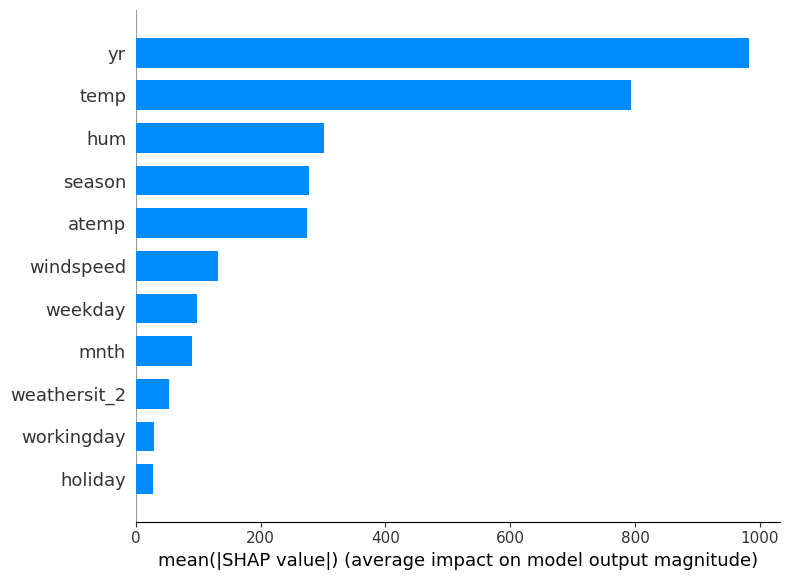

In [310]:
# Ejercicio 9b:

# ************* Inicia sección para agregar tu código:**************************
# Incluye todas las celdas que consideres necesarias.
shap_values = shap.TreeExplainer(best_model).shap_values(X_train_encoded)
shap.summary_plot(shap_values, X_train_encoded, plot_type="bar")

### **Ejercicio 9c:**

* **Incluye tu interpretación de los resultados obtenidos. En particular indica las coincidencias y diferencias entre ambos métodos de importancia de factores.**

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

Al usar el método feature importances, las variables que tienen mayor peso son año y temperatura (real y percibida) sin embargo si usamos el método Shap, las primeras dos se mantienen mientras que atem baja a la 5ta posición.

Esto se debe a que los árboles pueden usar las variables indistintamente, es decir la importancia se reparte entre ellas de forma arbitraria.

SHAP, en cambio, reparte el crédito entre las variables correlacionadas de forma más justa, lo que puede hacer que una suba y otra baje en el ranking.

**None**

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

## **Ejercicio - 10**

Incluye tus conclusiones finales de la actividad.

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

Incluye aquí tu respuesta.

**La clasificación y entendimiento del tipo de variables es crucial para el funcionamiento de un modelo, así como si reagrupación y transformación
En el caso de este modelo, podemos observar que los factores que más explican la cantidad de bicicletas rentadas por día están relacionados con la temperatura, sin embargo, la definición de la variable weathersit ha sido determinante para el funcionamiento del modelo, ya que a partir de su transformación, el modelo ha cambiado radicalmente su rendimiento

El aprendizaje que tengo de esta actividad es que siempre es importante validar el contenido de cada variable con perspectiva de negocio para obtener resultados más contundentes*

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

# **Fin de la Actividad de modelos basados en árboles**